# ELMo for Aspect-Target Sentiment Classification (Russian language) - 1

В этом ноутбуке мы попробуем применить модель ELMOCNN к ATSC на русском языке. Будем использовать предобученную ELMo модель от DeepPavlov.

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf

print(tf.__version__)

1.15.2


In [0]:
# !pip install deeppavlov

In [0]:
# !pip install transformers

In [0]:
import os
import gc
import zipfile
import random

import pandas as pd
import numpy as np
import torch
import gensim
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import bs4

from tqdm.notebook import tqdm

from deeppavlov.models.embedders.elmo_embedder import ELMoEmbedder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from transformers import AdamW

from google.colab import drive

USE_GOOGLE_DRIVE = True

sns.set(font_scale=1.2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


Примонтируем наш гугл-диск, если мы решили его использовать.

In [0]:
if USE_GOOGLE_DRIVE:
    drive.mount('/content/drive')
    PATH_PREFIX = 'drive/My Drive/NLP/dialog-sent'
else:
    PATH_PREFIX = '..'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_PREFIX = os.path.join(PATH_PREFIX, 'data')
MODEL_PREFIX = os.path.join(PATH_PREFIX, 'models')

Зададим девайс для обучения.

In [0]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Проинициализируем везде генераторы случайных чисел.

In [0]:
random_seed = 42
random_state = random_seed

def set_seed_everywhere(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if cuda:
        torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed, USE_GPU)

### Данные для русскоязычного датасета

Теперь надо разобраться с данными. Мы используем отзывы о рестранах. В каждом отзыве есть т.н. аспектные термины, по которым мы должны указать тональность. В качестве примера можно привести отзыв из датасета:
```xml
	<review id="15655">
		<meta>
			<object>Roll &amp; Roll</object>
			<user>kazah</user>
			<date>29.05.2010 18:39</date>
			<useful>1</useful>
		</meta>
		<scores>
			<food>10</food>
			<interior>10</interior>
			<service>10</service>
		</scores>
		<text>Сегодня посетили этот ресторан с девушкой. Очень понравилось. Интерьер отличный, все из дерева и очень красиво! Официанты внимательны и ненавязчивы! Играет приятная музыка! 
        Что касается кухни: Остался в восторге от теплого салата с говядиной, и конечно стейк из говядины! Еще не могу не отметить крем-суп из лосося! 
        Ребята просто молодцы - очень очень вкусно! И порции &quot;достойные&quot;. В общем были приятно удивлены таким замечательным местом, обязательно придем еще, и не один раз!</text>
		<aspects>
			<aspect category="Whole" from="22" mark="Rel" sentiment="neutral" term="ресторан" to="30" type="explicit"/>
			<aspect category="Interior" from="62" mark="Rel" sentiment="positive" term="Интерьер" to="70" type="explicit"/>
			<aspect category="Interior" from="81" mark="Rel" sentiment="positive" term="все из дерева" to="94" type="fct"/>
			<aspect category="Service" from="112" mark="Rel" sentiment="positive" term="Официанты" to="121" type="explicit"/>
			<aspect category="Service" from="122" mark="Rel" sentiment="positive" term="внимательны" to="133" type="implicit"/>
			<aspect category="Interior" from="165" mark="Rel" sentiment="positive" term="музыка" to="171" type="explicit"/>
			<aspect category="Food" from="186" mark="Rel" sentiment="positive" term="кухни" to="191" type="explicit"/>
			<aspect category="Food" from="215" mark="Rel" sentiment="positive" term="теплого салата с говядиной" to="241" type="explicit"/>
			<aspect category="Food" from="253" mark="Rel" sentiment="positive" term="стейк из говядины" to="270" type="explicit"/>
			<aspect category="Food" from="296" mark="Rel" sentiment="positive" term="крем-суп из лосося" to="314" type="explicit"/>
			<aspect category="Food" from="352" mark="Rel" sentiment="positive" term="вкусно" to="358" type="implicit"/>
			<aspect category="Food" from="362" mark="Rel" sentiment="positive" term="порции" to="368" type="explicit"/>
			<aspect category="Whole" from="432" mark="Rel" sentiment="positive" term="местом" to="438" type="explicit"/>
		</aspects>
		<categories>
			<category name="Food" sentiment="positive"/>
			<category name="Interior" sentiment="positive"/>
			<category name="Price" sentiment="absence"/>
			<category name="Whole" sentiment="positive"/>
			<category name="Service" sentiment="positive"/>
		</categories>
	</review>
```
Как видим, здесь весьма много аспектных терминов в отличие от англоязычного датасета. Аттрибуты from, to указывают на позицию термина в предложении.



Данные предоставлены в формате xml. Для работы с ними будем использовать beautiful soup.

In [0]:
def xml2pandas(data_path):
    """Перевод исходного датасета в формате xml в pandas-датафрейм."""
    data_dict = {'sentence_id': [], 'text': [], 'term': [],
                 'from': [], 'to': [], 'sentiment': []}

    with open(data_path, 'r') as inf:
        contents = inf.read()
        soup = bs4.BeautifulSoup(contents, 'xml')
        for review in soup.find_all('review'):
            # Если нет аспектных терминов
            if review.find('aspects') is None:
                continue
            terms = review.find('aspects').find_all(
                'aspect'
            )
            for term in terms:
                data_dict['term'].append(term['term'])
                data_dict['from'].append(term['from'])
                data_dict['to'].append(term['to'])
                data_dict['sentiment'].append(term['sentiment'])

                data_dict['sentence_id'].append(review['id'])
                data_dict['text'].append(review.find('text').text)

    data = pd.DataFrame(data_dict)
    data['from'] = data['from'].astype(int)
    data['to'] = data['to'].astype(int)
    return data

In [0]:
data_train_raw_path = os.path.join(
    DATA_PREFIX, 'raw', 'SentiRuEval-2015', 'SentiRuEval_rest_markup_train.xml'
)

data_test_raw_path = os.path.join(
    DATA_PREFIX, 'raw', 'SentiRuEval-2015', 'SentiRuEval_rest_markup_test.xml'
)

data_train = xml2pandas(data_train_raw_path)
data_test = xml2pandas(data_test_raw_path)

In [0]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторане,71,80,neutral
1,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторанах,198,208,neutral
2,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторане,256,265,neutral
3,3976,"День 8-го марта прошёл, можно и итоги подвести...",Столик бронировали,267,285,neutral
4,3976,"День 8-го марта прошёл, можно и итоги подвести...",сделали так как предложил администратор,296,335,positive


In [0]:
data_test.head()

,sentence_id,text,term,from,to,sentiment
0,37784,По совету друзей посетили данное заведение. Бы...,заведение,33,42,neutral
1,37784,По совету друзей посетили данное заведение. Бы...,Очень людно,68,79,negative
2,37784,По совету друзей посетили данное заведение. Бы...,пиво,93,97,positive
3,37784,По совету друзей посетили данное заведение. Бы...,большой выбор,104,117,positive
4,37784,По совету друзей посетили данное заведение. Бы...,кухни,122,127,neutral


Теперь, чтобы нормально это обучать надо как-то сохранить информацию о местопложении аспектных терминов (иначе токенизация порушит наши индексы, и они перестанут работать). В общем случае, нам надо хранить слайс индексов, которые будут отвечать за аспектный термин после токенизации.

Чтобы выполнить токенизацию и понять, где все еще находится аспектный термин, нам потребуется поставить какие-то маркеры. Попробуем проверить, что в наших текстах нет символов <, >, которыми мы обозначим границы аспектных терминов.

In [0]:
print(data_train['text'].apply(lambda x: '<' in x).sum())
print(data_test['text'].apply(lambda x: '>' in x).sum())
print(data_test['text'].apply(lambda x: '<' in x).sum())
print(data_test['text'].apply(lambda x: '>' in x).sum())

0
0
0
0


Обрамим аспектные термины символами <, >, чтобы потом после токенизации сразу понять, где они.

In [0]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторане,71,80,neutral
1,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторанах,198,208,neutral
2,3976,"День 8-го марта прошёл, можно и итоги подвести...",ресторане,256,265,neutral
3,3976,"День 8-го марта прошёл, можно и итоги подвести...",Столик бронировали,267,285,neutral
4,3976,"День 8-го марта прошёл, можно и итоги подвести...",сделали так как предложил администратор,296,335,positive


In [0]:
!python -m spacy download xx_ent_wiki_sm
!python -m spacy validate

✔ Download and installation successful
You can now load the model via spacy.load('xx_ent_wiki_sm')
✔ Loaded compatibility table

====================== Installed models (spaCy v2.2.4) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   xx-ent-wiki-sm   xx_ent_wiki_sm   2.2.0   ✔
package   en-core-web-sm   en_core_web_sm   2.2.5   ✔
link      en               en_core_web_sm   2.2.5   ✔



In [0]:
nlp = spacy.load('xx_ent_wiki_sm')

In [0]:
def tokenize(df_orig, nlp):
    df = df_orig.copy()
    from_tokens = []
    to_tokens = []
    tokenized_texts = []
    for i, row in df.iterrows():
        raw_text = row['text']
        from_index = row['from']
        to_index = row['to']
        text = (raw_text[:from_index] + '< ' + raw_text[from_index:to_index] 
                + ' >' + raw_text[to_index:])
        doc = nlp(text)
        tokens = [x.text for x in doc]
        tokenized_texts.append([x for x in tokens if x not in ['<', '>']])
        try:
            from_tokens.append(tokens.index('<') + 1)
            to_tokens.append(tokens.index('>'))
        except ValueError as e:
            print(raw_text)
            print(tokens)
    df['from'] = from_tokens
    df['to'] = to_tokens
    df['text'] = tokenized_texts
    return df

In [0]:
data_train = tokenize(data_train, nlp)
data_test = tokenize(data_test, nlp)
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",ресторане,15,16,neutral
1,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",ресторанах,34,35,neutral
2,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",ресторане,47,48,neutral
3,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",Столик бронировали,49,51,neutral
4,3976,"[День, 8-го, марта, прошёл, ,, можно, и, итоги...",сделали так как предложил администратор,53,58,positive


Проверим, что ничего не сломалось.

In [0]:
print(data_train['text'].apply(lambda x: '<' in ''.join(x)).sum())
print(data_train['text'].apply(lambda x: '>' in ''.join(x)).sum())
print(data_test['text'].apply(lambda x: '<' in ''.join(x)).sum())
print(data_test['text'].apply(lambda x: '>' in ''.join(x)).sum())

0
0
0
0


Теперь можем разделить данные на валидацию и трейн.

In [0]:
data_train, data_valid = train_test_split(
    data_train, test_size=0.2, random_state=random_state
)

print(f'TRAIN SIZE: {data_train.shape[0]}')
print(f'VALIDATE SIZE: {data_valid.shape[0]}')
print(f'TEST SIZE: {data_test.shape[0]}')

TRAIN SIZE: 3488
VALIDATE SIZE: 873
TEST SIZE: 5117


Посмотрим на сбалансированность классов.

In [0]:
np.unique(data_train.sentiment)

array(['both', 'negative', 'neutral', 'positive'], dtype=object)

In [0]:
np.unique(data_train.sentiment, return_counts=True)[1] / data_train.shape[0]

array([0.01290138, 0.17230505, 0.19466743, 0.62012615])

In [0]:
np.unique(data_valid.sentiment, return_counts=True)[1] / data_valid.shape[0]

array([0.01145475, 0.16609393, 0.18556701, 0.63688431])

In [0]:
np.unique(data_test.sentiment, return_counts=True)[1] / data_test.shape[0]

array([0.01700215, 0.18350596, 0.09595466, 0.70353723])

Классы, конечно, не сбалансированны, но доли классов на трейне и валидации очень близки. Смущает то, что доля нейтральных на тесте чуть ли не в два раза ниже, чем на трейне.

#### Получение эмбеддингов ELMo

Для получения ELMo эмбеддингов будем использовать DeepPavlov. В качестве примера будем использовать [официальный сайт](http://docs.deeppavlov.ai/en/master/apiref/models/embedders.html#deeppavlov.models.embedders.elmo_embedder.ELMoEmbedder). Можно заметить, что там уже идет обработка батча, поэтому никаким образом паддинги нам обрабатывать не надо, а потому torchtext не нужен.

На данный момент проблема в том, что ELMo, обученный на русском языке использует tensforlow. Вследствие этого во время обучения память на GPU расходуется как Tensorflow, так и PyTorch. Чтобы избежать этого сначала получим все эмбеддинги при помощи Tensorflow, а затем будем использовать их, как статику для PyTorch.

In [0]:
elmo = ELMoEmbedder("http://files.deeppavlov.ai/deeppavlov_data/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz", 
                    elmo_output_names=["lstm_outputs1", "lstm_outputs2"], 
                    pad_zero=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Проверим, что все работает.

In [0]:
data_train.text[0][:10]

['День',
 '8-го',
 'марта',
 'прошёл',
 ',',
 'можно',
 'и',
 'итоги',
 'подвести',
 '.']

In [0]:
elmo(data_train.text[:1].tolist()).shape

(1, 239, 2048)

Напишем цикл для получения эмбеддингов. Затем сохраним их на диск.

In [0]:
print(data_train.text.apply(lambda x: len(x)).max())
print(data_valid.text.apply(lambda x: len(x)).max())
print(data_test.text.apply(lambda x: len(x)).max())

273
273
277


Как видим, самый длинный текст состоит из 277 токенов. Поэтому будем выполнять padding до длины 280. Лучше сделать паддинг сразу для всех данных, потому что там можно будет удобно сохранить все сразу в numpy-матрице. Заметим, что мы будем использовать float32, потому что в float64 нет смысла для будущих тензорных вычислений.

In [0]:
def get_list_elmo_embeddings(elmo, dataset, pad_size=280):
    embeddings_list = []
    for text in tqdm(dataset):
        embeddings_text = elmo([text])[0]
        result = np.zeros((pad_size, embeddings_text.shape[1]))
        result[:embeddings_text.shape[0],:embeddings_text.shape[1]] = embeddings_text
        embeddings_list.append(result.astype(np.float32))
    return embeddings_list

In [0]:
# embeddings_train = get_list_elmo_embeddings(elmo, data_train.text)
# embeddings_train = np.stack(embeddings_train)
# with open(os.path.join(DATA_PREFIX, 'interim', 'elmo', 'embeddings_train_russian.npy'), 'wb') as ouf:
#     np.save(ouf, embeddings_train)

In [0]:
# embeddings_valid = get_list_elmo_embeddings(elmo, data_valid.text)
# embeddings_valid = np.stack(embeddings_valid)
# with open(os.path.join(DATA_PREFIX, 'interim', 'elmo', 'embeddings_valid_russian.npy'), 'wb') as ouf:
#     np.save(ouf, embeddings_valid)

In [0]:
# embeddings_test = get_list_elmo_embeddings(elmo, data_test.text)
# embeddings_test = np.stack(embeddings_test)
# with open(os.path.join(DATA_PREFIX, 'interim', 'elmo', 'embeddings_test_russian_2.npy'), 'wb') as ouf:
#     np.save(ouf, embeddings_test)

#### Создание датасета и даталоадера для обучения

In [0]:
sentiment_vocab = {'negative': 0, 'positive': 1, 'both': 2, 'neutral': 3}

In [0]:
class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, embeddings, sentiment_vocab):
        self.data = data
        self.embeddings = embeddings
        self.sentiment_vocab = sentiment_vocab

    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        embeddings = torch.tensor(self.embeddings[index])
        from_index = torch.tensor([self.data['from'].iloc[index]], 
                                  dtype=torch.long)
        to_index = torch.tensor([self.data['to'].iloc[index]], dtype=torch.long)
        sentiment = torch.tensor(
            [self.sentiment_vocab[self.data['sentiment'].iloc[index]]], 
            dtype=torch.long
        )
        return (embeddings, from_index, to_index, sentiment)

    def __len__(self):
        return len(self.data)

Проверим, что батчи работают правильно.

In [0]:
with open(os.path.join(DATA_PREFIX, 'interim', 'elmo', 'embeddings_train_russian.npy'), 'rb') as inf:
    embeddings_train = np.load(inf)

In [0]:
with open(os.path.join(DATA_PREFIX, 'interim', 'elmo', 'embeddings_valid_russian.npy'), 'rb') as inf:
    embeddings_valid = np.load(inf)

In [0]:
print(embeddings_train.shape)
print(embeddings_valid.shape)

(3488, 280, 2048)
(873, 280, 2048)


In [0]:
train_dataset = Dataset(data_train, embeddings_train, sentiment_vocab)
dataloader_train = DataLoader(train_dataset, batch_size=5, 
                              shuffle=True, num_workers=4)

for i_batch, (embeddings_batched, from_batched, to_batched, 
              sentiment_batched) in enumerate(dataloader_train):
    if i_batch == 1:
        break
    print(from_batched)
    print(from_batched.size())

tensor([[  5],
        [ 34],
        [148],
        [205],
        [ 49]])
torch.Size([5, 1])


### ELMoCNN

Возьмем лучшую модель из 5-db-elmo.ipynb.

In [0]:
class ELMOCNN(nn.Module):

    def __init__(self, num_sentiments, embeddings_dim, 
                 hidden_dim, kernel_sizes):
        super(ELMOCNN, self).__init__()

        self.elmo_lstm_coef_1 = nn.Parameter(torch.ones(1))
        self.elmo_lstm_coef_2 = nn.Parameter(torch.ones(1))

        self.embeddings_dim = embeddings_dim

        self.convs1 = nn.ModuleList(
            [nn.Conv1d(embeddings_dim, hidden_dim, kernel_size) 
            for kernel_size in kernel_sizes]
        )
        self.convs1_nonlin = nn.ReLU()
        self.convs1_dropout = nn.Dropout()

        self.to_sentiments = nn.Linear(2*len(kernel_sizes)*hidden_dim, 
                                       num_sentiments)

        # weights initializatioin
        torch.nn.init.uniform_(self.elmo_lstm_coef_1)
        torch.nn.init.uniform_(self.elmo_lstm_coef_2)
        torch.nn.init.xavier_uniform_(self.to_sentiments.weight)
        
    def forward(self, elmo_embeddings, from_indices, to_indices, hidden=None):
        # get weighted embeddings
        embeddings = (
            elmo_embeddings[:, :, self.embeddings_dim:]*self.elmo_lstm_coef_1
            + 
            elmo_embeddings[:, :, :self.embeddings_dim]*self.elmo_lstm_coef_2
        )

        # get bit matrix
        batch_size, seq_len, _ = embeddings.size()
        index_matrix = torch.repeat_interleave(
            torch.arange(seq_len).view(1, -1), batch_size, dim=0
        ).to(device=embeddings.device)
        bit_matrix = ((index_matrix >= from_indices) 
                      & (index_matrix < to_indices))
        # inverse bit matrix to work with context
        bit_matrix = ~bit_matrix
        # get average of embedings according to bit_matrix
        embeddings = embeddings*torch.unsqueeze(bit_matrix, -1)
        embeddings = torch.transpose(embeddings, 1, 2)
        x = [self.convs1_nonlin(conv(embeddings)) for conv in self.convs1]

        list_to_cat = [torch.max(y, 2)[0] for y in x]
        list_to_cat += [torch.mean(y, 2) for y in x]
        x = torch.cat(list_to_cat, 1)
        x = self.convs1_dropout(x)
        sentiments = self.to_sentiments(x)
        return sentiments

Инициализируем нашу сеть.

In [0]:
set_seed_everywhere(random_seed, USE_GPU)

num_sentiments = len(sentiment_vocab) - 1 # не учитываем both

hidden_dim = 32

model = ELMOCNN(
    num_sentiments, 1024, hidden_dim, [3, 5, 7]
)

#### Цикл обучения

In [0]:
def train_loop(train_iter, val_iter, model, opt, scheduler, criterion, epochs, 
               early_stopping, path_save, path_best_save, save_every_epoch=5):
    train_losses = []
    val_losses = []
    train_score_values = []
    val_score_values = []
    best_val_loss = 100
    best_val_score = 0
    not_improves = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0.0
        train_score = 0
        model.train() 
        for batch in tqdm(train_iter, leave=False): 

            embeddings, from_indices, to_indices, sentiments = batch
            embeddings = embeddings.to(device=device)
            from_indices = from_indices.to(device=device)
            to_indices = to_indices.to(device=device)
            sentiments = sentiments.to(device=device).squeeze(1)

            opt.zero_grad()
            preds = model(embeddings, from_indices, to_indices)

            loss = criterion(preds, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clipping_value)
            opt.step()
            train_loss += loss.item()

            pred_sentiments = torch.max(preds, dim=-1)[1]
            train_score += np.sum(
                pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
            )

        train_loss /= len(train_iter.dataset)
        train_losses.append(train_loss)
        train_score /= len(train_iter.dataset)
        train_score_values.append(train_score)

        val_loss = 0.0
        val_preds = []
        val_answers = []
        model.eval()
        with torch.no_grad():
            for batch in val_iter:

                embeddings, from_indices, to_indices, sentiments = batch
                embeddings = embeddings.to(device=device)
                from_indices = from_indices.to(device=device)
                to_indices = to_indices.to(device=device)
                sentiments = sentiments.to(device=device).squeeze(1)

                preds = model(embeddings, from_indices, to_indices)  
                loss = criterion(preds, sentiments)
                val_loss += loss.item()

                pred_sentiments = torch.max(preds, dim=-1)[1]
                val_preds += pred_sentiments.tolist()
                val_answers += sentiments.tolist()

        val_loss /= len(valid_iter.dataset)
        val_preds = np.array(val_preds)
        val_answers = np.array(val_answers)
        val_score = f1_score(val_answers, val_preds, average='macro')
        val_losses.append(val_loss)
        val_score_values.append(val_score)

        if val_score > best_val_score:
            not_improves = 0
            best_val_score = val_score
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'sheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'validate_losses': val_losses,
                'train_scores': train_score_values,
                'validate_scores': val_score_values,
                }, path_best_save)
            print('------SAVED BEST------')
        else:
            not_improves += 1
            if not_improves == early_stopping:
                break

        if (epoch-1) % save_every_epoch == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'sheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'validate_losses': val_losses,
                'train_scores': train_score_values,
                'validate_scores': val_score_values,
                }, path_save)
            print('------SAVED------')
        
        scheduler.step()

        print(f'Epoch: {epoch}, '
              f'Training Loss: {train_loss:.3f}, '
              f'Validation Loss: {val_loss:.3f}, '
              f'Validation Score: {val_score:.3f}')

    return train_losses, val_losses, train_score_values, val_score_values

Для того, чтобы получать сравнимые с соревнованием результаты, будем брать те же самые сентименты (там при расчете результатов не учитывался neutral).

In [0]:
remain_sentiments = ['positive', 'negative', 'both']
train_dataset = Dataset(
    data_train[data_train.sentiment.isin(remain_sentiments)], 
    embeddings_train,
    sentiment_vocab
)
valid_dataset = Dataset(
    data_valid[data_valid.sentiment.isin(remain_sentiments)], 
    embeddings_valid,
    sentiment_vocab
)

batch_size = 64

train_iter = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=False, num_workers=4)

valid_iter = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=4)

In [0]:
model = model.to(device=device)
learning_rate = 1e-3
early_stopping = 100
grad_clipping_value = 1
epochs = 20

opt = AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=1)
criterion = nn.CrossEntropyLoss(reduction='sum', 
                                weight=torch.tensor([3., 1., 10.], device=device))
path_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_cnn_russian.pt')
path_best_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_cnn_russian_best.pt')

In [0]:
set_seed_everywhere(random_seed, USE_GPU)
train_losses, val_losses, train_scores, val_scores = train_loop(
    train_iter, valid_iter, model, opt, scheduler, criterion, 
    epochs, early_stopping, path_save, path_best_save
)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


------SAVED BEST------
------SAVED------
Epoch: 1, Training Loss: 2.607, Validation Loss: 1.510, Validation Score: 0.350


Epoch: 2, Training Loss: 1.881, Validation Loss: 1.644, Validation Score: 0.344


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 3, Training Loss: 1.633, Validation Loss: 1.501, Validation Score: 0.336


Epoch: 4, Training Loss: 1.635, Validation Loss: 1.567, Validation Score: 0.346


------SAVED BEST------
Epoch: 5, Training Loss: 1.491, Validation Loss: 1.550, Validation Score: 0.354


------SAVED BEST------
------SAVED------
Epoch: 6, Training Loss: 1.451, Validation Loss: 1.529, Validation Score: 0.354


Epoch: 7, Training Loss: 1.416, Validation Loss: 1.526, Validation Score: 0.352


------SAVED BEST------
Epoch: 8, Training Loss: 1.383, Validation Loss: 1.514, Validation Score: 0.357


Epoch: 9, Training Loss: 1.399, Validation Loss: 1.516, Validation Score: 0.350


Epoch: 10, Training Loss: 1.364, Validation Loss: 1.513, Validation Score: 0.332


------SAVED BEST------
------SAVED------
Epoch: 11, Training Loss: 1.375, Validation Loss: 1.516, Validation Score: 0.358


------SAVED BEST------
Epoch: 12, Training Loss: 1.317, Validation Loss: 1.579, Validation Score: 0.365


Epoch: 13, Training Loss: 1.285, Validation Loss: 1.594, Validation Score: 0.350


Epoch: 14, Training Loss: 1.282, Validation Loss: 1.610, Validation Score: 0.343


Epoch: 15, Training Loss: 1.252, Validation Loss: 1.639, Validation Score: 0.352


------SAVED------
Epoch: 16, Training Loss: 1.249, Validation Loss: 1.635, Validation Score: 0.335


Epoch: 17, Training Loss: 1.233, Validation Loss: 1.645, Validation Score: 0.338


Epoch: 18, Training Loss: 1.267, Validation Loss: 1.629, Validation Score: 0.346


Epoch: 19, Training Loss: 1.253, Validation Loss: 1.665, Validation Score: 0.354


Epoch: 20, Training Loss: 1.194, Validation Loss: 1.719, Validation Score: 0.342



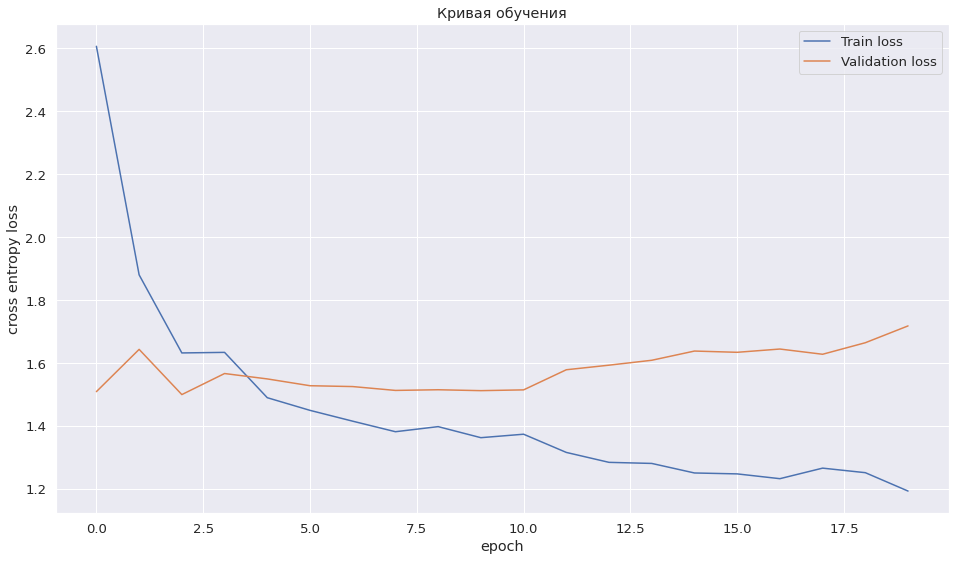

In [0]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Кривая обучения')
plt.legend()
plt.show()

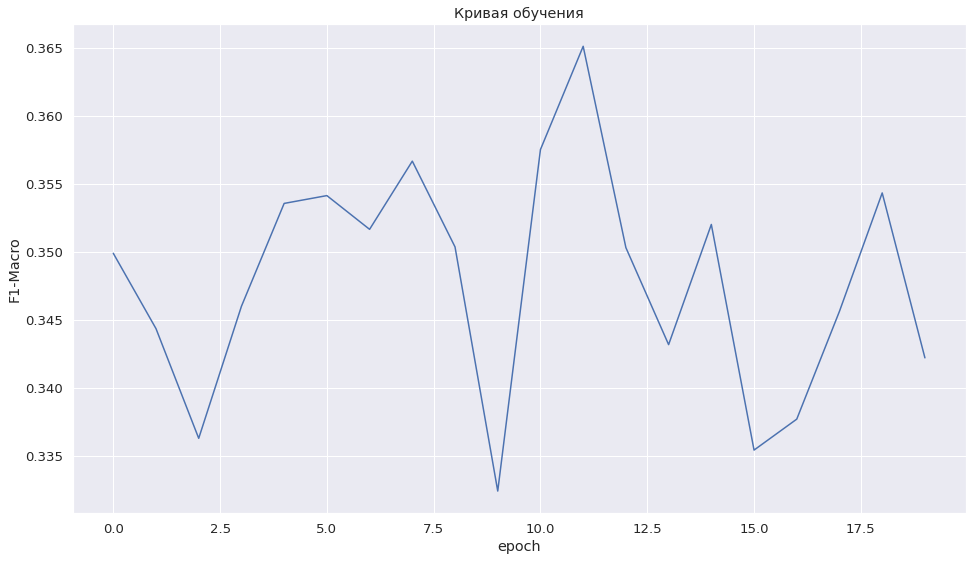

In [0]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), val_scores)
plt.xlabel('epoch')
plt.ylabel('F1-Macro')
plt.title('Кривая обучения')
plt.show()

Как видим, итоговое качество практически не менялось.

Измерим качество полученной модели.

In [0]:
checkpoint = torch.load(path_best_save)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [0]:
with open(os.path.join(DATA_PREFIX, 'interim', 'elmo', 'embeddings_test_russian_1.npy'), 'rb') as inf:
    embeddings_test_1 = np.load(inf)

In [0]:
remain_sentiments = ['both', 'positive', 'negative']
test_dataset = Dataset(
    data_test[data_test.sentiment.isin(remain_sentiments)][:2500], 
    embeddings_test_1,
    sentiment_vocab
)

test_iter = DataLoader(test_dataset, batch_size=64, 
                       shuffle=False, num_workers=4)

In [0]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in test_iter:

        embeddings, from_indices, to_indices, sentiments = batch
        embeddings = embeddings.to(device=device)
        from_indices = from_indices.to(device=device)
        to_indices = to_indices.to(device=device)
        sentiments = sentiments.to(device=device).squeeze(1)

        preds_scores = model(embeddings, from_indices, to_indices)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [0]:
np.unique(all_preds, return_counts=True)

(array([0, 1]), array([ 455, 2045]))

In [0]:
np.unique(all_answers, return_counts=True)

(array([0, 1, 2]), array([ 456, 2001,   43]))

In [0]:
accuracy = accuracy_score(all_answers, all_preds)
f_score_macro = f1_score(all_answers, all_preds, average='macro')
f_score_micro = f1_score(all_answers, all_preds, average='micro')

print(f'Accuracy: {accuracy:.3f}')
print(f'F1 Macro: {f_score_macro:.3f}')
print(f'F1 Micro: {f_score_micro:.3f}')

Accuracy: 0.720
F1 Macro: 0.368
F1 Micro: 0.720


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Результат оказался очень так себе. Лучшее решение на соответствующем датасете в SentiRuEval дало: 
* F1-Micro: $0.825$
* F1-Macro: $0.555$.

А наш результат:
* F1-Micro: $0.720$
* F1-Macro: $0.368$.

### Выводы

К сожалению, модель пока не удалось перенести с хорошим качеством. Возможные причины:
* Ошибка где-то в коде.
* ELMo на русском языке не дает такие хорошие эмбеддинги
* Плохо обрабатывается дизбаланс классов (об этом говорят результаты тестирования, где модель не угадала вообще класс both).